Part 3 of the assigment.

1. Selecting and plotting a signal in it's time and frequency domain. The first signal is  time-limited and the second one is band-limited. 

In [101]:
#install missing libraries
! pip install --upgrade numpy
! pip install --upgrade matplotlib

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import warnings
warnings.filterwarnings('ignore')
import sympy as sp
sp.init_printing() 
from matplotlib import style
style.use('bmh')
plt.rcParams['figure.figsize'] = 16, 6
import scipy.fftpack as fftpack

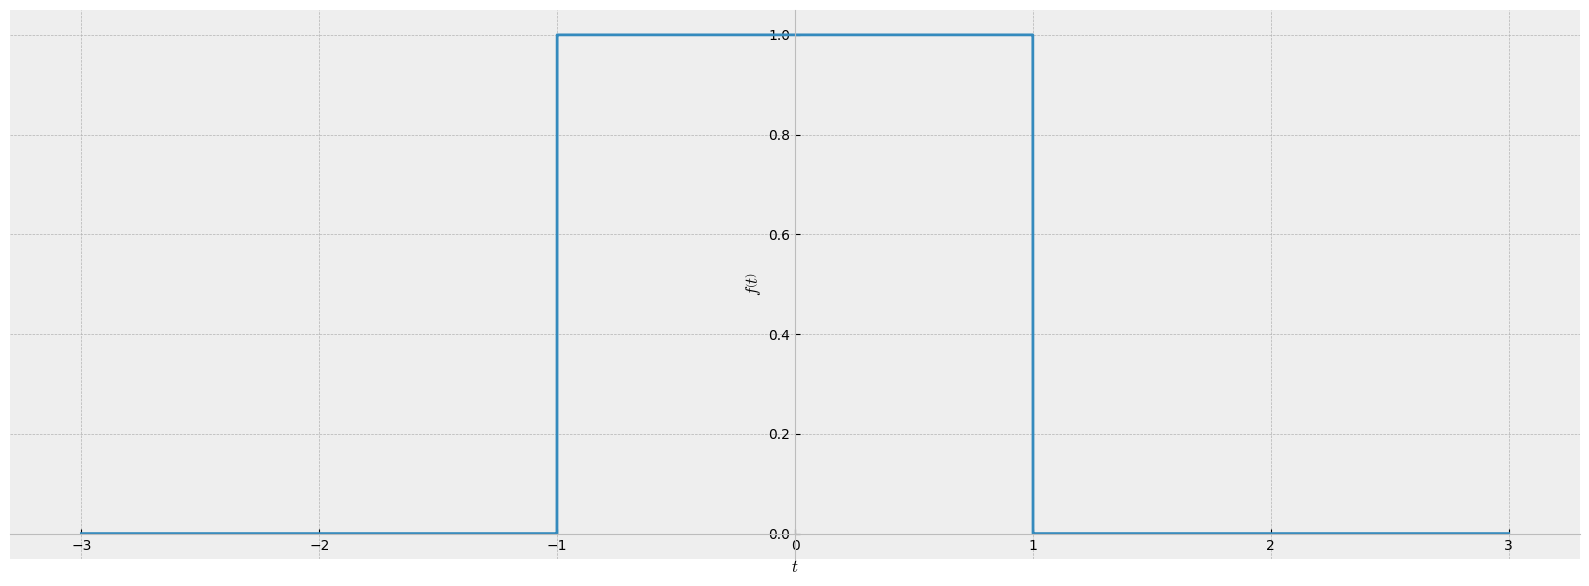

In [103]:
# a) Timelimited pulse in time domain constructed by two heaviside functions
t = sp.symbols('t')
sp.plot(sp.Heaviside(t+1) - sp.Heaviside(t-1), (t, -3, 3))

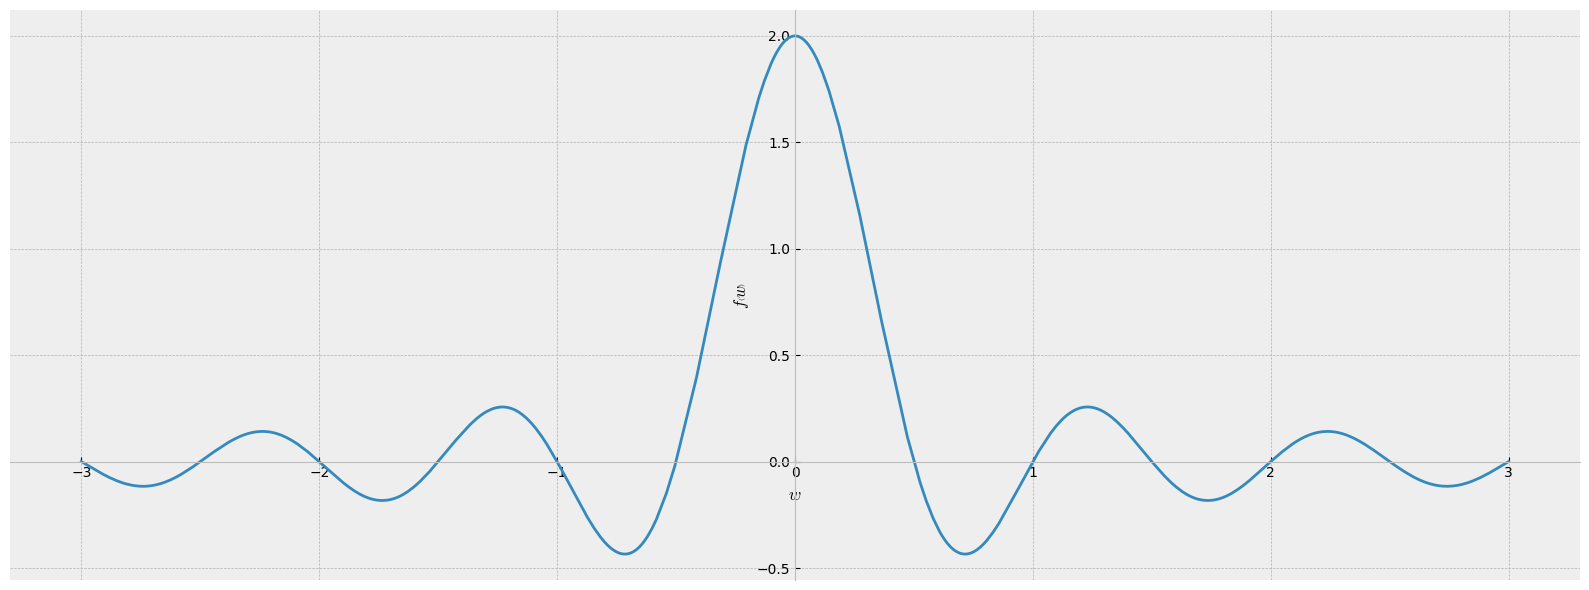

In [104]:
# a) Timelimited pulse in freaquency domain constructed by two heaviside functions

w = sp.symbols('w')
sp.plot(sp.fourier_transform(sp.Heaviside(t+1) - sp.Heaviside(t-1), t, w),(w,-3,3))

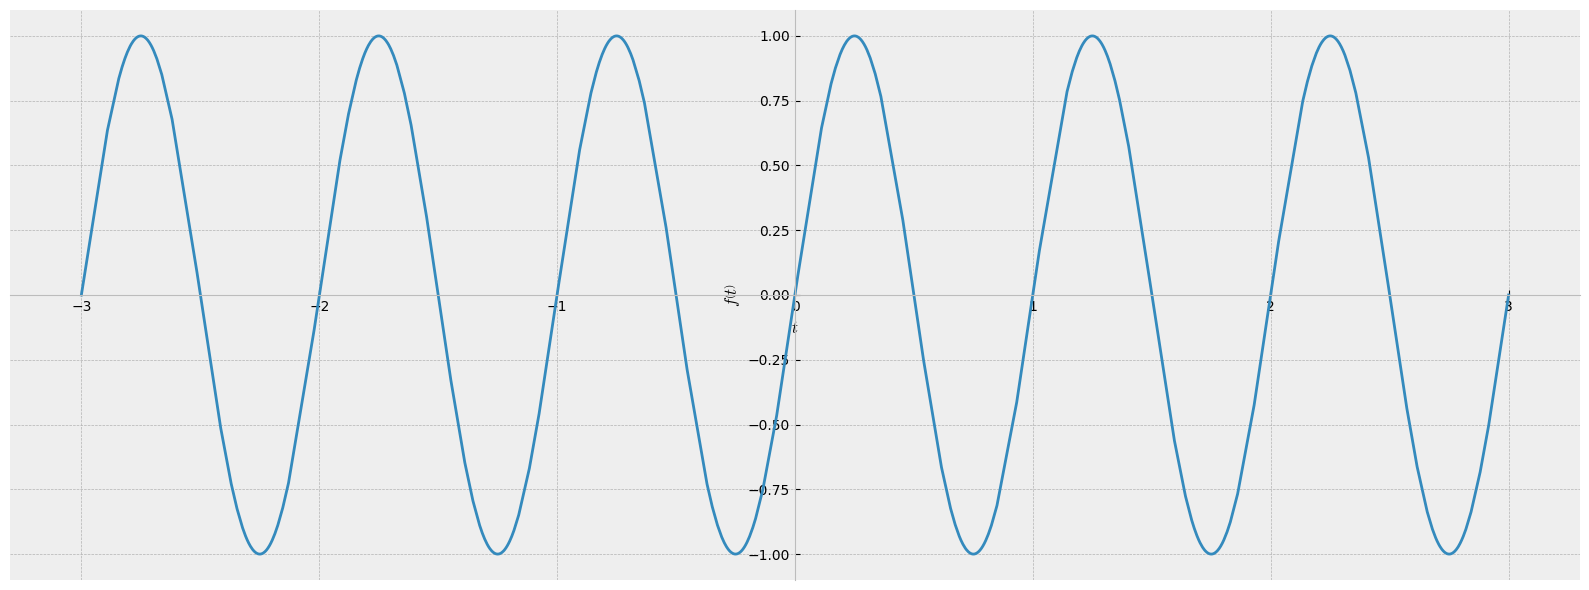

In [105]:
# b) band limited signal in time domain constructed of sin function

sp.plot(sp.sin(2*t*sp.pi), (t, -3, 3))

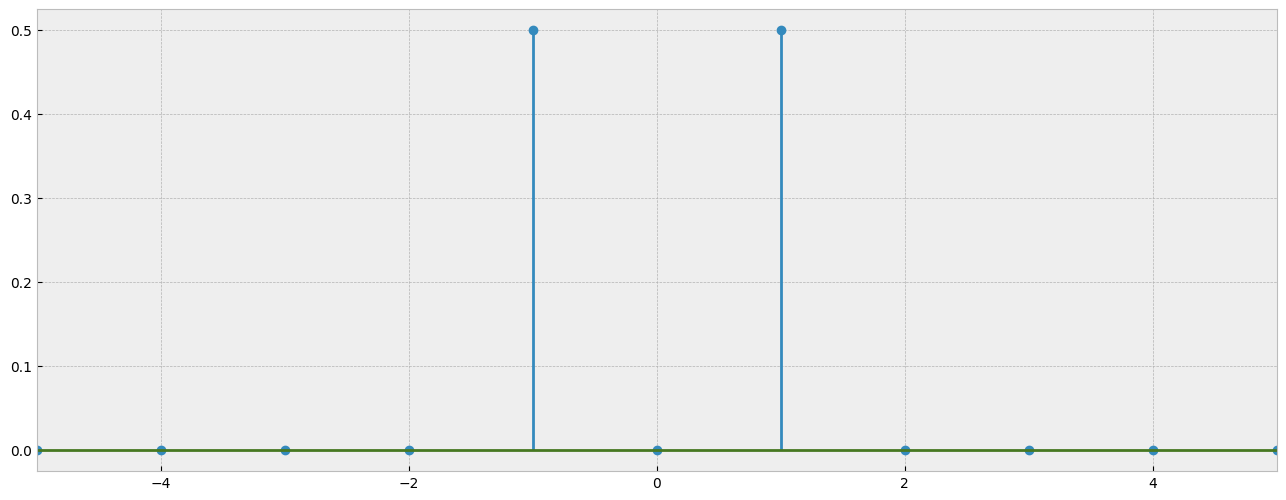

In [106]:
# b) band limited signal in frequency domain constructed of sin function
# Could not use the same sp.fourier_transform function as previously since with the sp.sin(2*t*sp.pi) the result is 0. I guess this is a bug with the library. More on here: https://groups.google.com/g/sympy/c/e8GiLUsr9eo
# Code is heavily inspired by the second week's note book on the course.
m = sp.sin(2*t*sp.pi)
m_converted = sp.lambdify(t, m, "numpy")
fig, ax = plt.subplots()
tp = np.linspace(0, 1, 10_000)
x = m_converted(tp)
X = fftpack.fft(x) / 10_000

freqs = fftpack.fftfreq(len(x)) * 10_000 
ax.stem(freqs, np.abs(X))
ax.set_xlim(-5, 5)